In [70]:
import pandas as pd

resolution = ''
#Change dimensions in ALL CELLS
prefix_path = ''
color = ''
ground_truth_prefix = ''
images_prefix = ''
segmented_images=''
test_segmented_images=''

In [71]:
# Dynamically construct the path to the Excel file based on the color variable
excel_file_path_training = prefix_path+'TrainingData.xlsx'
excel_file_path_testing = prefix_path+'TestingData.xlsx'


# Read the Excel file into a DataFrame
grapes_df = pd.read_excel(excel_file_path_training)
testing_grapes_df = pd.read_excel(excel_file_path_testing)

In [72]:
#grapes_df = grapes_df[grapes_df['Image'].str.contains(color)]
#testing_grapes_df = testing_grapes_df[testing_grapes_df['Image'].str.contains(color)]

In [73]:
# Update the 'Image' column to reflect the correct resolution, and prepend the prefix path

grapes_df['Image'] = prefix_path + images_prefix + grapes_df['Image'].str.replace('Resolution', resolution)
grapes_df['Mask'] = prefix_path + ground_truth_prefix + grapes_df['Mask'].str.replace('Resolution', resolution)

testing_grapes_df['Image'] = prefix_path + images_prefix + testing_grapes_df['Image'].str.replace('Resolution', resolution)
testing_grapes_df['Mask'] = prefix_path + ground_truth_prefix + testing_grapes_df['Mask'].str.replace('Resolution', resolution)

pd.set_option('display.max_colwidth', 500)
# Display the DataFrame
print(grapes_df.head())
print(testing_grapes_df.head())




                                                                                                           Image  \
0  /content/drive/MyDrive/Dataset/GrapeSet/Images/Green/WhiteBackground/Setup1/MediumResolution/A-B-C_SV180.jpeg   
1  /content/drive/MyDrive/Dataset/GrapeSet/Images/Green/WhiteBackground/Setup1/MediumResolution/A-D-G_SV180.jpeg   
2  /content/drive/MyDrive/Dataset/GrapeSet/Images/Green/WhiteBackground/Setup1/MediumResolution/A-F-J_SV180.jpeg   
3  /content/drive/MyDrive/Dataset/GrapeSet/Images/Green/WhiteBackground/Setup1/MediumResolution/B-I-G_SV180.jpeg   
4  /content/drive/MyDrive/Dataset/GrapeSet/Images/Green/WhiteBackground/Setup1/MediumResolution/D-B-H_SV180.jpeg   

                                                                                Mask  \
0  /content/drive/MyDrive/Dataset/GrapeSet/GroundTruth/Green/Setup1/A-B-C_SV180.jpeg   
1  /content/drive/MyDrive/Dataset/GrapeSet/GroundTruth/Green/Setup1/A-D-G_SV180.jpeg   
2  /content/drive/MyDrive/Dataset/Grape

In [74]:
len(grapes_df)


440

In [75]:
len(testing_grapes_df)

120

In [76]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, df, image_column, mask_column, batch_size=32, target_size=(480, 640)):
        self.df = df
        self.image_column = image_column
        self.mask_column = mask_column
        self.batch_size = batch_size
        self.target_size = target_size
        self.indexes = np.arange(len(df))

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        masks = []
        for _, row in batch_df.iterrows():
            img_path = row[self.image_column]
            mask_path = row[self.mask_column]

            img = load_img(img_path, target_size=self.target_size)
            mask = load_img(mask_path, color_mode='grayscale', target_size=self.target_size)

            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
            mask = (mask > 0.5).astype(np.float32)  # Ensure binary mask

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

In [77]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K



# Define IoU metric for model evaluation
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

# Simplified U-Net model architecture
def simplified_unet(input_size=(480, 640, 3)):
    inputs = Input(input_size)
    # Downsampling
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

    # Upsampling
    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Assuming 'grapes_df' is your DataFrame with columns 'Image' and 'Masks' for paths
target_size = (480, 640)
batch_size = 8

train_generator = DataGenerator(grapes_df, 'Image', 'Mask', batch_size=batch_size, target_size=target_size)

model = simplified_unet(input_size=(target_size[0], target_size[1], 3))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[iou])

history = model.fit(train_generator, epochs=50, verbose=1)


Epoch 1/50
55/55 [==============================] - 46s 760ms/step - loss: 0.2405 - iou: 0.1502
Epoch 2/50
55/55 [==============================] - 44s 800ms/step - loss: 0.1405 - iou: 0.4628
Epoch 3/50
55/55 [==============================] - 46s 827ms/step - loss: 0.0807 - iou: 0.6010
Epoch 4/50
55/55 [==============================] - 42s 766ms/step - loss: 0.0512 - iou: 0.7244
Epoch 5/50
55/55 [==============================] - 43s 774ms/step - loss: 0.0426 - iou: 0.7704
Epoch 6/50
55/55 [==============================] - 44s 803ms/step - loss: 0.0395 - iou: 0.7861
Epoch 7/50
55/55 [==============================] - 44s 787ms/step - loss: 0.0354 - iou: 0.8033
Epoch 8/50
55/55 [==============================] - 44s 804ms/step - loss: 0.0377 - iou: 0.7894
Epoch 9/50
55/55 [==============================] - 43s 779ms/step - loss: 0.0364 - iou: 0.7968
Epoch 10/50
55/55 [==============================] - 41s 741ms/step - loss: 0.0301 - iou: 0.8285
Epoch 11/50
55/55 [====================

In [81]:
test_generator = DataGenerator(testing_grapes_df, 'Image', 'Mask', batch_size=batch_size, target_size=target_size)


In [82]:
# Evaluate the model on the test set using the IoU metric
test_loss, test_iou = model.evaluate(test_generator, verbose=1)
test_iou_rounded = np.round(test_iou, 2)

print("Test IoU:", test_iou_rounded)

15/15 [==============================] - 11s 711ms/step - loss: 0.0162 - iou: 0.9137
Test IoU: 0.91


In [83]:
import numpy as np
from sklearn.metrics import f1_score

def calculate_f1_score(model, generator):
    # Placeholder for predictions and actuals
    y_pred = []
    y_true = []

    # Iterate over the generator
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        preds = model.predict(x_batch)

        # Flatten the outputs and labels to compute F1-score on a pixel level
        y_pred.extend(preds.flatten())
        y_true.extend(y_batch.flatten())

    # Threshold predictions to binary values (0 or 1)
    y_pred_binary = np.array(y_pred) > 0.5

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred_binary)

    return f1

# Assuming your model and test_generator are correctly defined
f1 = calculate_f1_score(model, test_generator)

f1_rounded = np.round(f1, 2)

print("F-1 Score:", f1_rounded)


1/1 [==============================] - 0s 43ms/step
F-1 Score: 0.97


In [84]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path, target_size=(480, 640)):
    """Load an image and preprocess it."""
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


1/1 [==============================] - 0s 35ms/step
(1, 480, 640, 1)


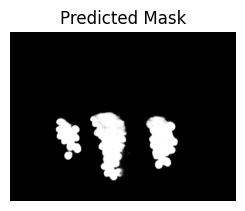

In [85]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = testing_grapes_df['Image'].iloc[1]

test_img = load_and_preprocess_image(image_path, target_size=(480, 640))

predicted_mask = model.predict(test_img)
print(predicted_mask.shape)

plt.subplot(1, 2, 2)

plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


In [86]:
import os

# Iterate over each row in the DataFrame
for index, row in testing_grapes_df.iterrows():
    # Get the image path
    image_path = row['Image']

    # Load and preprocess the image (using your earlier defined function)
    test_img = load_and_preprocess_image(image_path, target_size=(480, 640))

    # Predict the mask (using your model, as previously defined)
    predicted_mask = model.predict(test_img)

    # Convert the predicted mask to a binary image
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Remove the batch dimension and channel dimension from the binary mask
    binary_mask = binary_mask[0, :, :, 0]

    # Convert the binary mask to a three channel image
    binary_mask_3ch = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)

    # Load the original image
    original_image = cv2.imread(image_path)

    # Ensure the binary mask is the same size as the original image
    binary_mask_3ch_resized = cv2.resize(binary_mask_3ch, (original_image.shape[1], original_image.shape[0]))

    # Use the binary mask to extract the segmented grapes from the original image
    segmented_grapes = cv2.bitwise_and(original_image, original_image, mask=binary_mask_3ch_resized[:, :, 0])

    # Get the path to save the segmented image
    save_path = row['Image'].replace('Images/', 'TestSegmentedImages/')
    save_dir = os.path.dirname(save_path)

    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    print(save_path)
    # Save the segmented image
    cv2.imwrite(save_path, segmented_grapes)


1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/Setup1/MediumResolution/A-B-C_SV0.jpeg
1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/Setup1/MediumResolution/A-D-G_SV0.jpeg
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/Setup1/MediumResolution/A-F-J_SV0.jpeg
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/Setup1/MediumResolution/B-I-G_SV0.jpeg
1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/Setup1/MediumResolution/D-B-H_SV0.jpeg
1/1 [==============================] - 0s 23ms/step
/content/drive/MyDrive/Dataset/GrapeSet/TestSegmentedImages/Green/WhiteBackground/S